<div style="background-color:rgba(0, 255, 0, 0.1); padding:15px;margin:5px">
<center> <h1>Speech Separation with Non Negative Matrix factorization</h1></center>


<span>**Done by :  Ayoub Choukri
</span>**
</div>



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Introduction

Speech separation is the task of separating a mixture of speech signals into individual speech signals. It is a challenging problem because the number of sources is unknown and the sources overlap in the time-frequency domain. Nowadays, deep learning methods are the most popular methods for speech separation. However, in this notebook, we will use a classical method called Non-negative Matrix Factorization (NMF) to separate speech signals.


<div style="display: flex; justify-content: space-between;">
    <img src="Images/source_separation_io.png" alt="Source Separation IO" style="width: 45%;">
    <img src="Images/Audio-source-separation.ppm" alt="Audio Source Separation" style="width: 45%;">
</div>


More generally, we will consider an audio signal $s_f(t)$ as a linear combination of $K$ sources $s_k(t)$:

$$s_f(t) = \sum_{k=1}^{K} s_k(t)$$

The final goal is to estimate the sources $s_k(t)$ from the mixture signal $s_f(t)$. One big challenge is to estimate the sources when the number of sources $K$ is unknown.



# Non-negative Matrix Factorization (NMF)

## Statement of the problem


Consider a matrix $V \in \mathcal{M}_{d \times n}(\mathbb{R^+})$ a non-negative matrix. The goal of NMF is to find two non-negative matrices $W \in \mathcal{M}_{d \times r}(\mathbb{R^+})$ and $H \in \mathcal{M}_{r \times n}(\mathbb{R^+})$ such that:

$$V \approx WH$$

where $r$ is the rank of the approximation and $r < \min(d, n)$. The matrices $W$ and $H$ are called the basis and the activation matrices, respectively.

More generally, if $r < \frac{d\times n}{d+n}$, then the resulting factorization can be considered as a compression of the original matrix $V$.


## Uniqueness of the factorization

We must note that the NMF factorization is not unique. Indeed, if $W$ and $H$ are a factorization of $V$, then $W \times D$ and $D^{-1} \times H$ is also a factorization of $V$ for any invertible matrix $D$.

Indeed,

$$V = WH = WDD^{-1}H = (WD)(D^{-1}H)$$

Thus, the factorization is not unique. For this reason, adding constraints to the factorization is important to get a unique factorization.

## Cost functions

In order to solve the NMF problem, we need to define a cost function to minimize. Therefore the solution of our problem would be the following :

$$
\min_{W \geq 0, H \geq 0} \mathcal{L}(V, WH)
$$



 The typical cost-function used in NMF are the following : 


### Frobenius norm

The Frobenius norm is the most common cost function used in NMF. It is defined as follows:

$$\text{Frobenius}(A,B) = \|A-B\|_{\text{F}}^2 = \sum_{i,j} (A_{ij} - B_{ij})^2 = \text{Tr}((A-B)^T(A-B))$$


Il faut remarquer que $$\text{Frobenius}(\lambda A, \lambda B) = \lambda^2 \text{Frobenius}(A,B)$$



In [2]:
def Frobenius(A,B):
    return np.trace((A-B)@(A-B).T)

### Kullback-Leibler divergence

The Kullback-Leibler divergence is another cost function used in NMF. It is defined as follows:

$$\text{KL}(A,B) = \sum_{i,j} A_{ij} \log \left(\frac{A_{ij}}{B_{ij}}\right) - A_{ij} + B_{ij}$$

Il faut remarquer que $$\text{KL}(\lambda A, \lambda B) = \lambda \text{KL}(A,B)$$

In [3]:
def KL_Divergence(A,B):
    return np.sum(A*np.log(A/B)-A+B)

### Itakura-Saito divergence

The Itakura-Saito divergence is another cost function used in NMF. It is defined as follows:

$$\text{IS}(A,B) = \sum_{i,j} \frac{A_{ij}}{B_{ij}} - \log \left(\frac{A_{ij}}{B_{ij}}\right) - 1$$

Il faut remarquer que $$\text{IS}(\lambda A, \lambda B) =\text{IS}(A,B)$$


The itakura-Saito divergence is the most used cost function in audio source separation.

In [4]:
def IS_Divergence(A,B):
    return  np.sum(A/B - np.log(A/B)-1)

# The $\beta$-divergence

The $\beta$-divergence is a generalization of the Kullback-Leibler divergence, the Itakura-Saito divergence, and the Frobenius norm. It is defined as follows:

$$\text{D}_{\beta}(A,B) = \begin{cases} 
\sum_{i,j} \frac{A_{ij}^\beta + (1-\beta)B_{ij}^\beta - \beta A_{ij}B_{ij}^{\beta-1}}{\beta(\beta-1)} & \text{if } \beta \neq 0, 1 \\
\sum_{i,j} A_{ij} \log \left(\frac{A_{ij}}{B_{ij}}\right) - A_{ij} + B_{ij} & \text{if } \beta = 1 \\
\sum_{i,j} \frac{A_{ij}}{B_{ij}} - \log \left(\frac{A_{ij}}{B_{ij}}\right) - 1 & \text{if } \beta = 0
\end{cases}$$

We notice that the Frobenius norm is the $\beta$-divergence with $\beta = 2$, the Kullback-Leibler divergence is the $\beta$-divergence with $\beta = 1$, and the Itakura-Saito divergence is the $\beta$-divergence with $\beta = 0$.

## Solving Algorithms

There exist several algorithms to solve the NMF problem. The most popular algorithms are:

*   Alternating Least Squares (ALS)
*   Multiplicative Update Rules (MU)

### Alternating (Constrained) Least Squares (ALS)
Because the NMF problem is an underdetermined problem, we need to add regularization terms to get a unique solution. The Constrained ALS algorithm solves the following optimization problem using the Frobenius norm:
$$ 
\min_{W \geq 0, H \geq 0} \|V - WH\|_{\text{F}}^2 + \lambda_W \|W\|_{\text{F}}^2 + \lambda_H \|H\|_{\text{F}}^2
$$

where $\lambda_H$ and $\lambda_W$ are regularization parameters.

The Constrained ALS algorithm solves the following optimization problem:

1.   Fix $W$ and update $H$ by solving the following optimization problem:

$$H_{n+1} = \arg \min_{H \geq 0} \mathcal{L}(V, WH_n) + \lambda_H \|H\|$$

i.e.

$$(W_{n}^TW_{n} + \lambda_H I)H_{n+1} = W_{n}^TV$$
2.   Set to $0$ all negative values of $H_{n+1}$.

3.   Fix $H$ and update $W$ by solving the following optimization problem:

$$W_{n+1} = \arg \min_{W \geq 0} \mathcal{L}(V, W_nH) + \lambda_W \|W\|$$

i.e.

$$(H_{n+1}H_{n+1}^T + \lambda_W I)W_{n+1}^T = HV^T$$

4.   Set to $0$ all negative values of $W_{n+1}$.

5.   Repeat steps 1 to 4 until convergence.


* **Remark** :  
    *   One main idea behind the ALS algorithm is that usually, the cost function is convex with respect to $W$ when $H$ is fixed and convex with respect to $H$ when $W$ is fixed, but not convex with respect to both $W$ and $H$. Therefore, the ALS algorithm can not guarantee to find the global minimum of the cost function. Moreover, there is no guarantee of convergence to a local minimum.
    *   The ALS algorithm works well in practise and has a fast convergence rate.

> Let's implement the ALS algorithm to solve the NMF problem.

In [5]:
def ALS(V,r,lamda_H,lambda_W,n_iter_max=500,eps=1e-5):
    W = np.random.rand(V.shape[0],r)
    Errors = []
    for i in range(n_iter_max):
        H = np.linalg.solve(W.T@W+lamda_H*np.eye(W.shape[1]),W.T@V)
        W = np.linalg.solve(H@H.T+lambda_W*np.eye(H.shape[0]),H@V.T).T

        Errors.append(Frobenius(V,W@H))

        if i>0 and Frobenius(V,W@H)<eps:
            return W,H,Errors
    
    return W,H,Errors


def ALS_Multiple_Runs(V,r,lamda_H,lambda_W,n_runs=10,n_iter_max=500,eps=1e-5):
    W_best = None
    H_best = None
    Error_best = np.inf
    Errors_Best_Run = None
    for i in range(n_runs):
        W,H,Errors = ALS(V,r,lamda_H,lambda_W,n_iter_max,eps)
        if Errors[-1]<Error_best:
            W_best = W
            H_best = H
            Error_best = Errors[-1]
            Errors_Best_Run = Errors
    return W_best,H_best,Errors_Best_Run




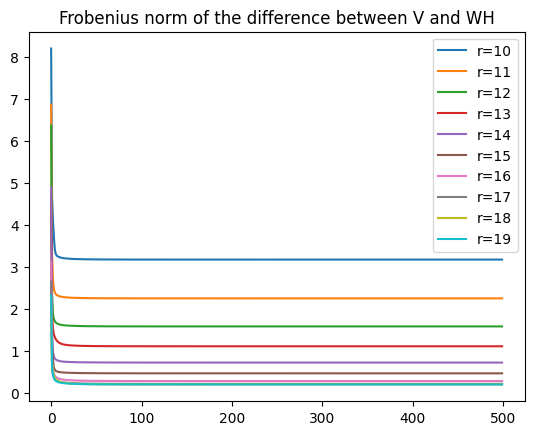

In [6]:
def Test_ALS(n=10,d=10):
    V = np.random.rand(n,d)
    lamda_H = 0.1
    lambda_W = 0.1

    plt.figure()
    for r in range(min(V.shape[0],V.shape[1]) -10 , min(V.shape[0],V.shape[1])):

        W,H,Errors = ALS(V,r,lamda_H,lambda_W)

        plt.plot(range(len(Errors)),Errors,label=f'r={r}')
    plt.legend()
    plt.title('Frobenius norm of the difference between V and WH')

Test_ALS(n=20,d=20)

> We notice that more $r$ is high, more the factorization is accurate. However, the computational cost is high. Therefore, we need to find the best $r$ that gives a good factorization with a low computational cost.

### Multiplicative Update Rules (MU)

The idea behind the MU algorithm is to update the matrices $W$ and $H$ by using multiplicative update rules. More precisely, the MU algorithm can be considered as a gradient descent algorithm with a well chosen step size.

#### Frobenius norm

Let's compute the gradient of the Frobenius norm with respect to $W$ and $H$:

We denote $\mathcal{L}(W, H) = \frac{1}{2}\|V - WH\|_{\text{F}}^2$.


Then,

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial H} &= -W^T(V-WH) = W^TWH - W^TV \\
\frac{\partial \mathcal{L}}{\partial W} &= -(V-WH)H^T = WHH^T - VH^T
\end{align*}
$$

Hence, the update rules would be for a given step size $\eta$:

$$
\begin{align*}
H_{n+1} &= H_n + \eta W^T(V-WH) \\
W_{n+1} &= W_n + \eta (V-WH)H^T
\end{align*}
$$

If we use a very small step size, the gradient descent would guarantee to converge to a local minimum.

However, Seung and Lee proposed to use a very well chosen step size to guarantee the convergence of the algorithm. 

Indeed, if we rewrite the update rules for each element of $W$ and $H$, we get:

$$
\begin{align*}
H_{ij} &= H_{ij} + \eta_H ((W^TV)_{ij} - (W^TWH)_{ij}) \\
W_{ij} &= W_{ij} + \eta_W ((VH^T)_{ij} - (WHH^T)_{ij})
\end{align*}
$$

where $\eta_H$ and $\eta_W$ are the step sizes for $H$ and $W$, respectively.

Now if we rescale the step sizes by the following:

$$
\begin{align*}
\eta_H &= \frac{H_{ij}}{(W^TWH)_{ij}} \\
\eta_W &= \frac{W_{ij}}{(WHH^T)_{ij}}
\end{align*}
$$


Then, the update rules become:

$$
\begin{align*}
H_{ij} &= H_{ij} \frac{(W^TV)_{ij}}{(W^TWH)_{ij}} \\
W_{ij} &= W_{ij} \frac{(VH^T)_{ij}}{(WHH^T)_{ij}}
\end{align*}
$$


Seung and Lee proved that the update rules guarantee the convergence of the algorithm. Moreover, the Frobenius norm in non-increasing during the iterations.






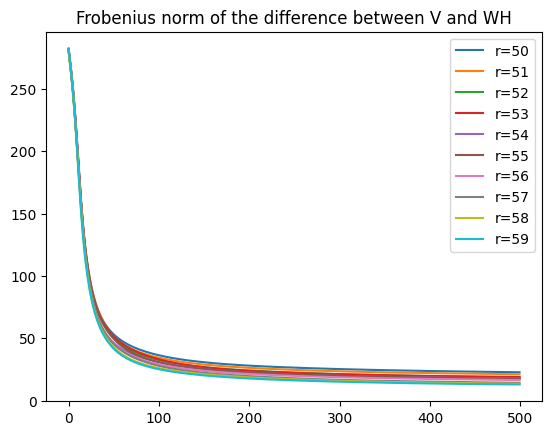

In [7]:
def NMF_Frobenius_Multiplicative(V,r,n_iter_max=500,eps=1e-5):
    """
    V: the matrix to be factorized
    r: the rank of the factorization
    n_runs: number of runs of the algorithm
    n_iter_max: maximum number of iterations
    eps: the stopping criterion
    """

    # Initialize initial values of W and H
    W = np.random.rand(V.shape[0],r)
    W = np.maximum(W,1e-10)
    H = np.random.rand(r,V.shape[1])
    

    Errors = []
    for i in range(n_iter_max):
        # Update H
        H = H * (W.T@V) / (W.T@W@H+1e-10)
        # Update W
        W = W * (V@H.T) / (W@H@H.T+1e-10)


        # Compute the error
        Errors.append(Frobenius(V,W@H))

        if i>0 and Frobenius(V,W@H)<eps:
            return W,H,Errors
        
    return W,H,Errors


def NMF_Frobenius_Multiplicative_Multiple_Runs(V,r,n_runs=10,n_iter_max=500,eps=1e-5):
    W_best = None
    H_best = None
    Error_best = np.inf
    Errors_Best_Run = None
    for i in range(n_runs):
        W,H,Errors = NMF_Frobenius_Multiplicative(V,r,n_iter_max,eps)
        if Errors[-1]<Error_best:
            W_best = W
            H_best = H
            Error_best = Errors[-1]
            Errors_Best_Run = Errors
    return W_best,H_best,Errors_Best_Run



def Test_NMF_Frobenius_Multiplicative(n=10,d=10):
    V = np.random.rand(n,d)

    plt.figure()
    for r in range(min(V.shape[0],V.shape[1]) -10 , min(V.shape[0],V.shape[1])):

        W,H,Errors = NMF_Frobenius_Multiplicative(V,r)

        plt.plot(range(len(Errors)),Errors,label=f'r={r}')
    plt.legend()
    plt.title('Frobenius norm of the difference between V and WH')



Test_NMF_Frobenius_Multiplicative(n=60,d=60)



#### Kullback-Leibler divergence

Following the same idea, we can compute the gradient of the Kullback-Leibler divergence with respect to $W$ and $H$:

We denote $\mathcal{L}(W, H) =Dl(V, WH) = \sum_{i,j} V_{ij} \log \left(\frac{V_{ij}}{(WH)_{ij}}\right) - V_{ij} + (WH)_{ij}$.

Then,


Let's compute the gradient of the Kullback-Leibler divergence with respect to $W$ and $H$:

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial H_{st}} &= \sum_{i=1}^{d} W_{is} \left(1-\frac{V_{it}}{(WH)_{it}} \right) \\
\frac{\partial \mathcal{L}}{\partial W_{st}} &= \sum_{j=1}^{n} H_{tj} \left(1-\frac{V_{sj}}{(WH)_{sj}} \right)
\end{align*}
$$


The multiplicative update rules for the Kullback-Leibler divergence are:

$$
\begin{align*}
H_{ij} &= H_{ij} \frac{\sum_a W_{ai}V_{aj}/(WH)_{aj}}{\sum_a W_{ai}} \\
W_{ij} &= W_{ij} \frac{\sum_a H_{ja}V_{ia}/(WH)_{ia}}{\sum_a H_{ja}}
\end{align*}
$$








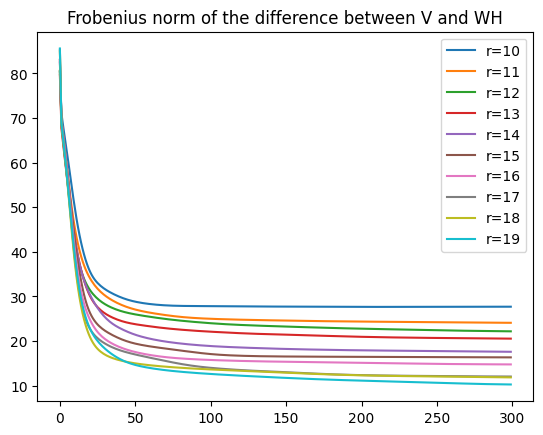

In [8]:
def NMF_Divergence_Multiplicative(V,r,n_iter_max=500,eps=1e-5):
    """
    V: the matrix to be factorized
    r: the rank of the factorization
    n_runs: number of runs of the algorithm
    n_iter_max: maximum number of iterations
    eps: the stopping criterion
    """

    def Update_H(V,W,H):
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                S=0
                for a in range(W.shape[0]):
                    S+= (W[a,i]*V[a,j] / (W[a,:]@H[:,j]+1e-10)) 
                H[i,j] = H[i,j] * S / np.sum(W[:,i])
        return H
    
    def Update_W(V,W,H):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                S=0
                for a in range(H.shape[1]):
                    S+= (H[j,a]*V[i,a] / (W[i,:]@H[:,a]+1e-10)) 
                W[i,j] = W[i,j] * S / np.sum(H[j,:])
        return W
    

    # Initialize initial values of W and H
    W = np.random.rand(V.shape[0],r)
    W= np.maximum(W,1e-10)
    H = np.random.rand(r,V.shape[1])
    H= np.maximum(H,1e-10)
    
    Errors = []
    for i in range(n_iter_max):
        # Update H
        H = Update_H(V,W,H)
        # Update W
        W = Update_W(V,W,H)


        # Compute the error
        Errors.append(Frobenius(V,W@H))

        if i>0 and Frobenius(V,W@H)<eps:
            return W,H,Errors
        
    return W,H,Errors


def NMF_Divergence_Multiplicative_Multiple_Runs(V,r,n_runs=10,n_iter_max=50,eps=1e-5):
    W_best = None
    H_best = None
    Error_best = np.inf
    Errors_Best_Run = None
    for i in range(n_runs):
        W,H,Errors = NMF_Divergence_Multiplicative(V,r,n_iter_max,eps)
        if Errors[-1]<Error_best:
            W_best = W
            H_best = H
            Error_best = Errors[-1]
            Errors_Best_Run = Errors
    return W_best,H_best,Errors_Best_Run


def Test_NMF_Divergence_Multiplicative(n=10,d=10):
    V = np.random.rand(n,d)

    plt.figure()
    for r in range(min(V.shape[0],V.shape[1]) -20 , min(V.shape[0],V.shape[1])-10):

        W,H,Errors = NMF_Divergence_Multiplicative(V,r,n_iter_max=300)

        plt.plot(range(len(Errors)),Errors,label=f'r={r}')
    plt.legend()
    plt.title('Frobenius norm of the difference between V and WH')



Test_NMF_Divergence_Multiplicative(n=30,d=30)

#### Itakura-Saito divergence

Following the same steps, we first recall that the Itakura-Saito divergence is defined as follows:

$$\text{IS}(V,WH) = \sum_{i,j} \frac{V_{ij}}{(WH)_{ij}} - \log \left(\frac{V_{ij}}{(WH)_{ij}}\right) - 1$$

Then, the gradient of the Itakura-Saito divergence with respect to $W$ and $H$ are:

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial W_{st}} &= \sum_{j=1}^{n} \frac{H_{tj}}{(WH)_{sj}} \left(1- \frac{V_{sj}}{(WH)_{sj}}\right) \\
\frac{\partial \mathcal{L}}{\partial H_{st}} &= \sum_{i=1}^{d} \frac{W_{is}}{(WH)_{it}} \left(1- \frac{V_{it}}{(WH)_{it}}\right)
\end{align*}
$$


The multiplicative update rules for the Itakura-Saito divergence are:

$$
\begin{align*}
H_{st} &= H_{st} \frac{\sum_{i=1}^{d} W_{is}V_{it}/(WH)_{it}}{\sum_{i=1}^{d} W_{is}} \\
W_{st} &= W_{st} \frac{\sum_{j=1}^{n} H_{tj}V_{sj}/(WH)_{sj}}{\sum_{j=1}^{n} H_{tj}}
\end{align*}
$$





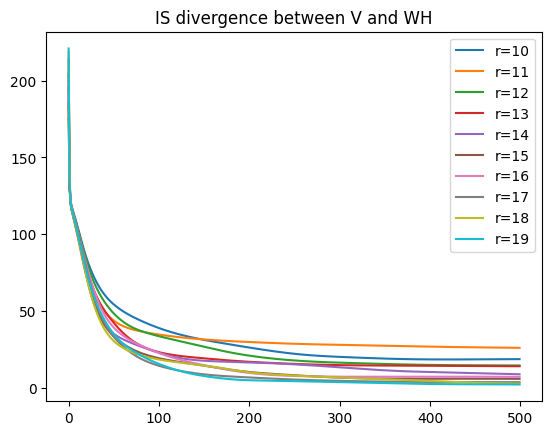

In [9]:
def NMF_IS_Multiplicative(V,r,n_iter_max=500,eps=1e-5):
    """
    V: the matrix to be factorized
    r: the rank of the factorization
    n_runs: number of runs of the algorithm
    n_iter_max: maximum number of iterations
    eps: the stopping criterion
    """

    def Update_H(V,W,H):
        for s in range(H.shape[0]):
            for t in range(H.shape[1]):
                S=0
                for i in range(W.shape[0]):
                    S+= (W[i,s]*V[i,t] / (W[i,:]@H[:,t]+1e-10))
                H[s,t] = H[s,t] * np.sqrt( S / np.sum(W[:,s]))
        return H
    
    def Update_W(V,W,H):
        for s in range(W.shape[0]):
            for t in range(W.shape[1]):
                S=0
                for j in range(H.shape[1]):
                    S+= (H[t,j]*V[s,j] / (W[s,:]@H[:,j]+1e-10))
                W[s,t] = W[s,t] * np.sqrt(S / np.sum(H[t,:]))

        return W


    # Initialize initial values of W and H
    W = np.random.rand(V.shape[0],r)
    W = W.clip(min=0)
    H = np.random.rand(r,V.shape[1])
    H = H.clip(min=0)

    Errors = []
    for i in range(n_iter_max):
        # Update H
        H = Update_H(V,W,H)
        # Update W
        W = Update_W(V,W,H)


        # Compute the error
        Errors.append(IS_Divergence(V,W@H))

        if i>0 and IS_Divergence(V,W@H)<eps:
            return W,H,Errors
        
    return W,H,Errors



def NMF_IS_Multiplicative_Multiple_Runs(V,r,n_runs=10,n_iter_max=500,eps=1e-5):
    W_best = None
    H_best = None
    Error_best = np.inf
    Errors_Best_Run = None
    for i in range(n_runs):
        W,H,Errors = NMF_IS_Multiplicative(V,r,n_iter_max,eps)
        if Errors[-1]<Error_best:
            W_best = W
            H_best = H
            Error_best = Errors[-1]
            Errors_Best_Run = Errors
    return W_best,H_best,Errors_Best_Run


def Test_NMF_IS_Multiplicative(n=10,d=10):
    V = np.random.rand(n,d)
    V

    plt.figure()
    for r in range(min(V.shape[0],V.shape[1]) -10 , min(V.shape[0],V.shape[1])):

        W,H,Errors = NMF_IS_Multiplicative(V,r)

        plt.plot(range(len(Errors)),Errors,label=f'r={r}')
    plt.legend()
    plt.title('IS divergence between V and WH')

Test_NMF_IS_Multiplicative(n=20,d=20)

# Application to Speech Separation

## Load the data

Le'ts first upload the different libraries that we will use in this notebook.

*   librosa : a python package for music and audio analysis
*   numpy : a python package for scientific computing
*   matplotlib : a python package for plotting
*   IPython.display : a python package for displaying audio signals

In [10]:
import numpy as np
import matplotlib.pyplot
import librosa
import IPython.display as ipd

In [11]:
# Variable that contains the path to the audio file
audio_file = './piano_mix.wav'

Let's load the audio and listen to it. We will use the `librosa` package to load the audio signal.

For the sample rate, we will use 5512 Hz in order to have a good quality of the audio signal and to reduce the computational cost.

In [12]:
sample_rate = 5512
# The function librosa.load loads the audio file and returns the audio signal and the sample rate of the audio
audio_sound, sample_rate = librosa.load(audio_file, sr = sample_rate)
# The shape of the audio signal
shape= audio_sound.shape

# printing information about the audio signal
print(f"Shape of the audio signal: {shape}")
print(f"Sample rate of the audio signal: {sample_rate}")
# Let's listen to the audio 
ipd.Audio(audio_sound,rate = sample_rate)

Shape of the audio signal: (19252,)
Sample rate of the audio signal: 5512


> We can hear that in the end of the audio signal, the three notes are played simultaneously. This is the part that we will try to separate using NMF.

> An other way to visualize the audio signal is to plot the waveform of the audio signal. The waveform is nothing but the amplitude of the audio signal as a function of time.

Let's show the sound waveform

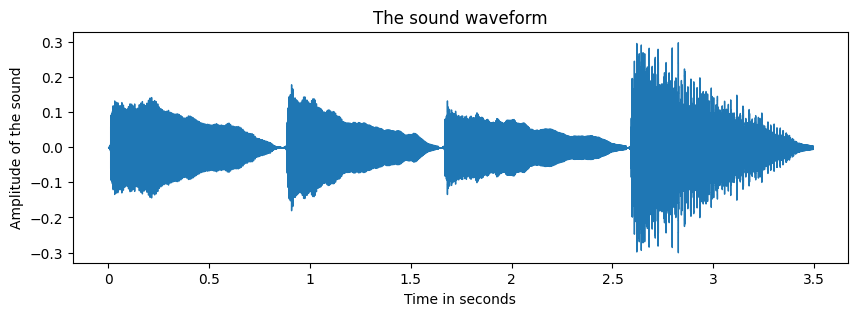

In [13]:
# Plotting the sound's waveform
fig, ax = plt.subplots(figsize=(10, 3))
# The function librosa.display.waveshow plots the waveform of the audio signal
librosa.display.waveshow(audio_sound, sr=sample_rate, ax=ax,axis='time')
ax.set_ylabel('Amplitude of the sound')
ax.set(title='The sound waveform', xlabel='Time in seconds')
plt.show()



## Short-Time Fourier Transform (STFT)

### Definition

The sort time Fourier transform is a technique used to analyze the frequency content of a signal as it changes over time. The STFT is computed by applying the Fourier transform to short overlapping windows of the signal. The STFT of a signal $x(t)$ is defined as follows:

$$X(m, \omega) = \sum_{k=-\infty}^{\infty} x(k)w(k-m)e^{-j\omega k}$$

where $w(k)$ is the window function, $m$ is the time index, and $\omega$ is the frequency index.



Let's make the short-time Fourier transform of the signal

In [14]:
# The Short Term Fourier Transform parameters
## FRAME is the size of the window
FRAME = 512
## HOP is the number of samples between two consecutive windows
HOP = 256

# Return the complex Short Term Fourier Transform
sound_stft = librosa.stft(audio_sound, n_fft = FRAME, hop_length = HOP)

The short-time Fourier transform is a complex matrix. We can plot the magnitude of the STFT to visualize the frequency content of the signal as a function of time.

The magnitude of the STFT is given by $|X(m, \omega)|^2 $

Let's plot the magnitude of the STFT of the signal.

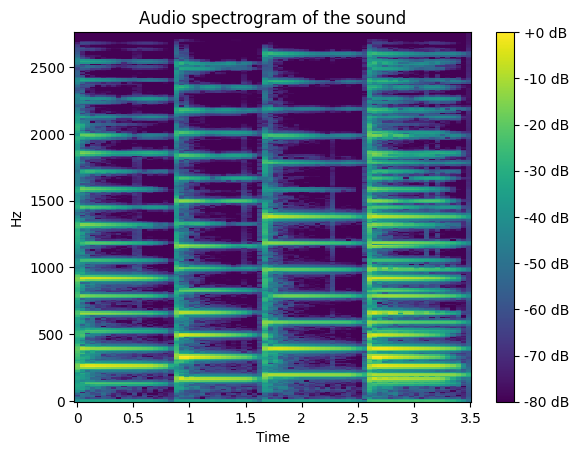

In [15]:
# Magnitude Spectrogram computed from the complex Short Term Fourier Transform
sound_stft_Magnitude = np.abs(sound_stft)

# Phase spectrogram computed from the complex Short Term Fourier Transform
sound_stft_Angle = np.angle(sound_stft)

#Plot Spectogram
plt.figure()
# We convert the magnitude spectrogram to decibels using the function amplitude_to_db
Spec = librosa.amplitude_to_db(sound_stft_Magnitude, ref = np.max)
librosa.display.specshow(Spec,y_axis = 'hz',sr=sample_rate,hop_length=HOP,x_axis ='time',cmap='viridis')
plt.title('Audio spectrogram of the sound')
plt.colorbar(format='%+2.0f dB')

plt.show()

> We notice that during the first 2 seconds, the signal is composed of three notes played one after the other. However, in the last 2 seconds, the three notes are played simultaneously. This is the part that we will try to separate using NMF.

## NMF for speech separation

We will introduce an error to add to the Magnitude of the STFT of the signal. This error will make the computation of the NMF feasible.

In [16]:
epsilon = 1e-10 # error to introduce
V = sound_stft_Magnitude + epsilon
K, N = np.shape(V)
S = 3 
print(f"S = {S} : Number of Sources to separate")

S = 3 : Number of Sources to separate


Let's compute the NMF of the magnitude of the STFT of the signal using the three cost functions: Frobenius norm, Kullback-Leibler divergence, and Itakura-Saito divergence.

In [17]:
W_Frobenius, H_Frobenius, Errors_Frobenius = NMF_Frobenius_Multiplicative_Multiple_Runs(V,S,n_runs=10,n_iter_max=500,eps=1e-5)

In [18]:
W_Divergence, H_Divergence, Errors_Divergence = NMF_Divergence_Multiplicative_Multiple_Runs(V,S,n_runs=10,n_iter_max=300,eps=1e-5)

In [ ]:
W_IS, H_IS, Errors_IS = NMF_IS_Multiplicative_Multiple_Runs(V,S,n_runs=2,n_iter_max=300,eps=1e-5)

**Plotting the cost Function**

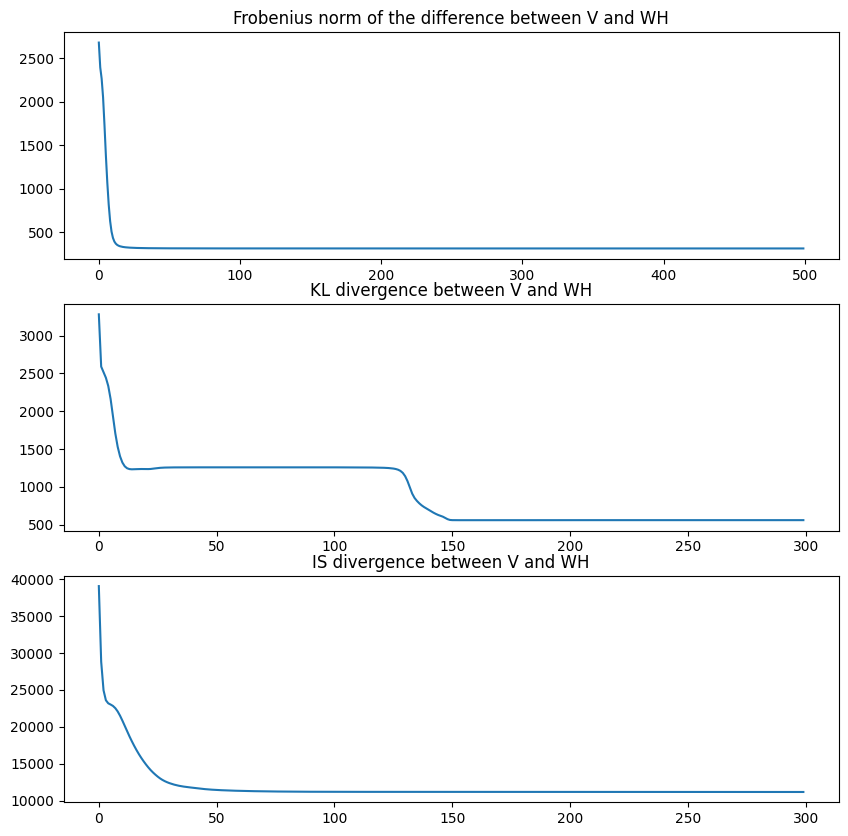

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(range(len(Errors_Frobenius)),Errors_Frobenius)
ax[0].set_title('Frobenius norm of the difference between V and WH')
ax[1].plot(range(len(Errors_Divergence)),Errors_Divergence)
ax[1].set_title('KL divergence between V and WH')
ax[2].plot(range(len(Errors_IS)),Errors_IS)
ax[2].set_title('IS divergence between V and WH')
plt.show()



> We notice that the Frobenius norm is the cost function that decreases the fastest. However, the Frobenius norm is not the best cost function for audio source separation. 

### Spectrograms of the recovered sources

> Let's plot the spectrograms of the recovered sources using the Frobenius norm.

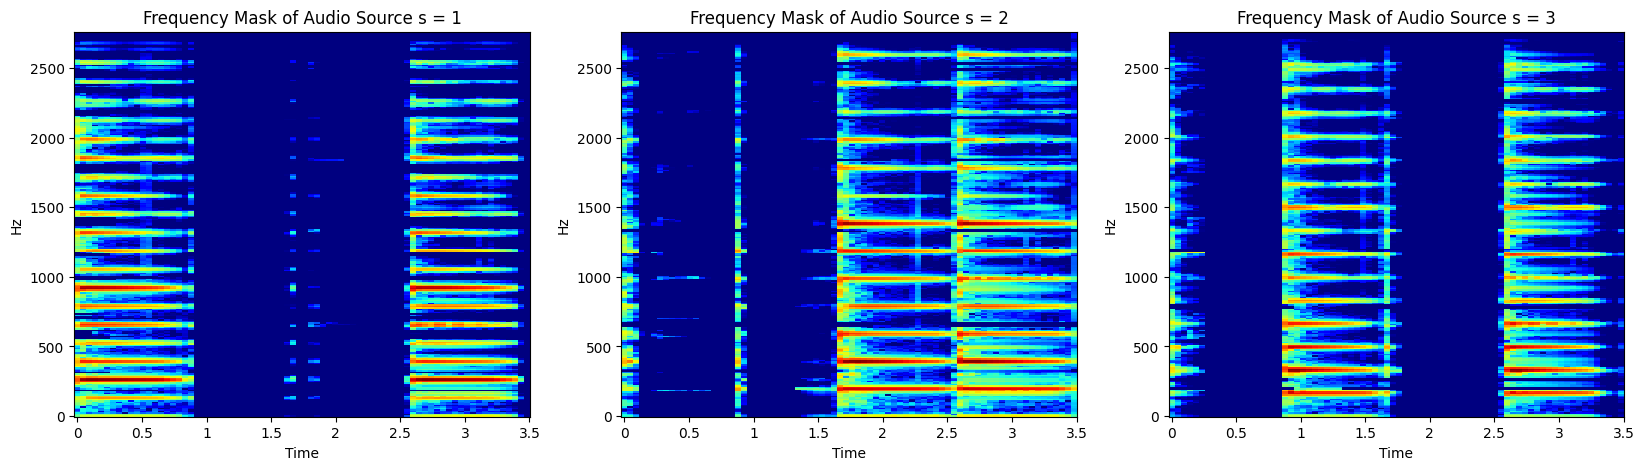

In [ ]:

#After NMF, each audio source S can be expressed as a frequency mask over time
f, axs = plt.subplots(nrows=1, ncols=S,figsize=(20,5))
filtered_spectrograms_Frobenius = []
for i in range(S):
    axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}") 
    # Filter eash source components
    WsHs = W_Frobenius[:,[i]]@H_Frobenius[[i],:]
    filtered_spectrogram = W_Frobenius[:,[i]]@H_Frobenius[[i],:] /(W_Frobenius@H_Frobenius) * V 
    # Compute the filtered spectrogram
    D = librosa.amplitude_to_db(filtered_spectrogram, ref = np.max)
    # Show the filtered spectrogram
    librosa.display.specshow(D,y_axis = 'hz', sr=sample_rate,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax = axs[i])
    
    filtered_spectrograms_Frobenius.append(filtered_spectrogram)

plt.suptitle('Filtered Spectrograms using NMF with Frobenius norm')

> We see clearly that the method converged and extracted the three piano notes played simultaneously.

Let's now plot the spectrograms of the recovered sources using the Kullback-Leibler divergence.

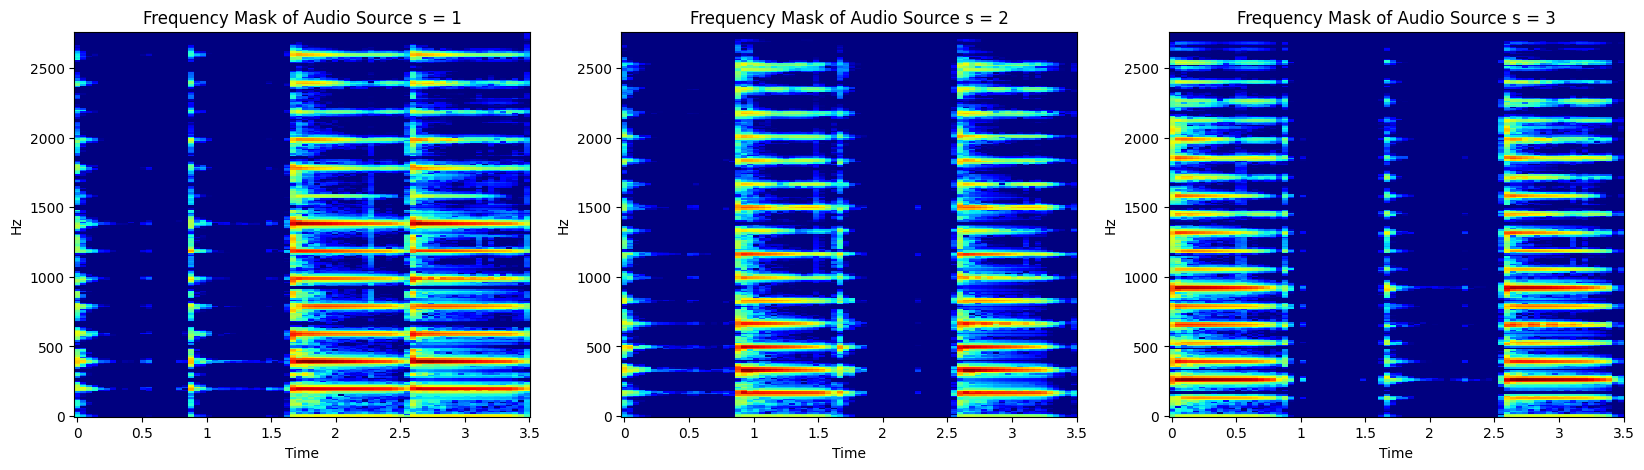

In [50]:

#After NMF, each audio source S can be expressed as a frequency mask over time
f, axs = plt.subplots(nrows=1, ncols=S,figsize=(20,5))
filtered_spectrograms_Divergence = []
for i in range(S):
    axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}") 
    # Filter eash source components
    WsHs = W_Divergence[:,[i]]@H_Divergence[[i],:]
    filtered_spectrogram = W_Divergence[:,[i]]@H_Divergence[[i],:] /(W_Divergence@H_Divergence) * V 
    # Compute the filtered spectrogram
    D = librosa.amplitude_to_db(filtered_spectrogram, ref = np.max)
    # Show the filtered spectrogram
    librosa.display.specshow(D,y_axis = 'hz', sr=sample_rate,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax = axs[i])
    
    filtered_spectrograms_Divergence.append(filtered_spectrogram)


plt.suptitle('Filtered Spectrograms using NMF with KL divergence')

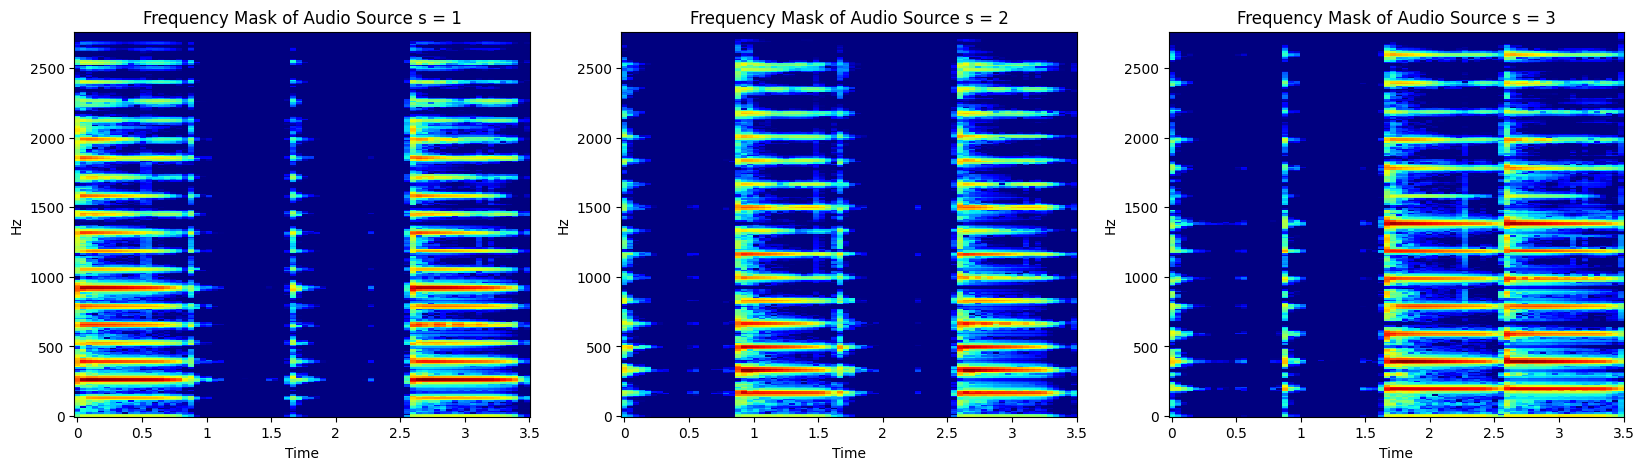

In [51]:

#After NMF, each audio source S can be expressed as a frequency mask over time
f, axs = plt.subplots(nrows=1, ncols=S,figsize=(20,5))
filtered_spectrograms_IS = []
for i in range(S):
    axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}") 
    # Filter eash source components
    WsHs = W_IS[:,[i]]@H_IS[[i],:]
    filtered_spectrogram = W_IS[:,[i]]@H_IS[[i],:] /(W_IS@H_IS) * V 
    # Compute the filtered spectrogram
    D = librosa.amplitude_to_db(filtered_spectrogram, ref = np.max)
    # Show the filtered spectrogram
    librosa.display.specshow(D,y_axis = 'hz', sr=sample_rate,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax = axs[i])
    
    filtered_spectrograms_IS.append(filtered_spectrogram)

plt.suptitle('Filtered Spectrograms using NMF with IS divergence')

### **05. Reconstruction the different audio signal corresponding to each extracted source**

In [52]:
reconstructed_sounds_Frobenius = []
for i in range(S):
    reconstruct = filtered_spectrograms_Frobenius[i] * np.exp(1j*sound_stft_Angle)
    new_sound   = librosa.istft(reconstruct, n_fft = FRAME, hop_length = HOP)
    reconstructed_sounds_Frobenius.append(new_sound)

In [53]:
reconstructed_sounds_Divergence = []
for i in range(S):
    reconstruct = filtered_spectrograms_Divergence[i] * np.exp(1j*sound_stft_Angle)
    new_sound   = librosa.istft(reconstruct, n_fft = FRAME, hop_length = HOP)
    reconstructed_sounds_Divergence.append(new_sound)

In [54]:
reconstructed_sounds_IS = []
for i in range(S):
    reconstruct = filtered_spectrograms_IS[i] * np.exp(1j*sound_stft_Angle)
    new_sound   = librosa.istft(reconstruct, n_fft = FRAME, hop_length = HOP)
    reconstructed_sounds_IS.append(new_sound)

/tmp/ipykernel_136557/470832822.py:5: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sounds_Frobenius[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')


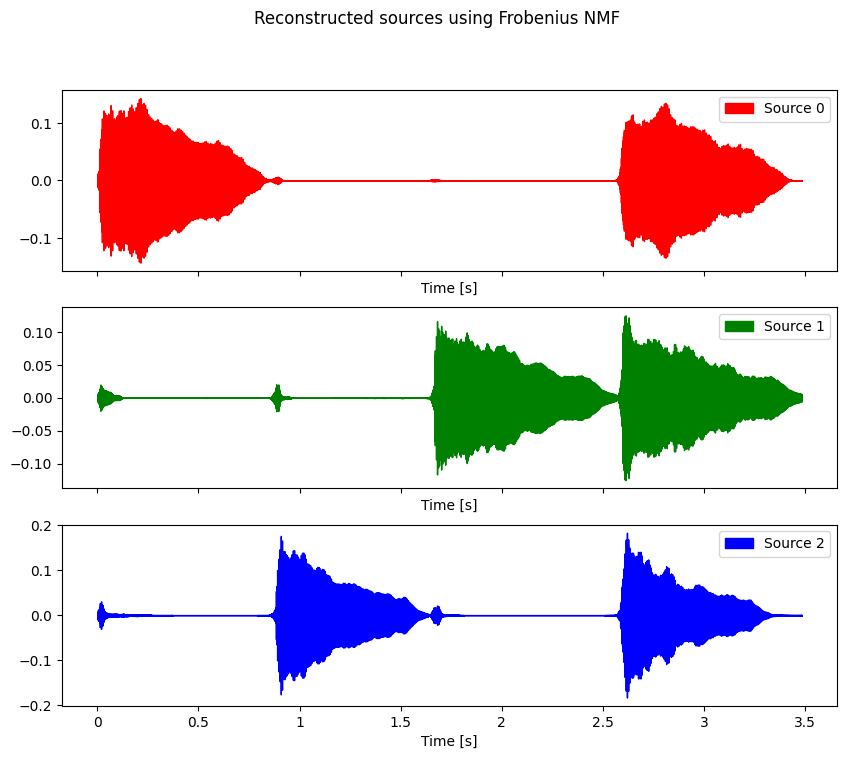

In [57]:
# Plotting the waveform
colors = ['r', 'g','b','c']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sounds_Frobenius[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()


plt.suptitle('Reconstructed sources using Frobenius NMF')
plt.show()

/tmp/ipykernel_136557/352814224.py:5: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sounds_Divergence[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')


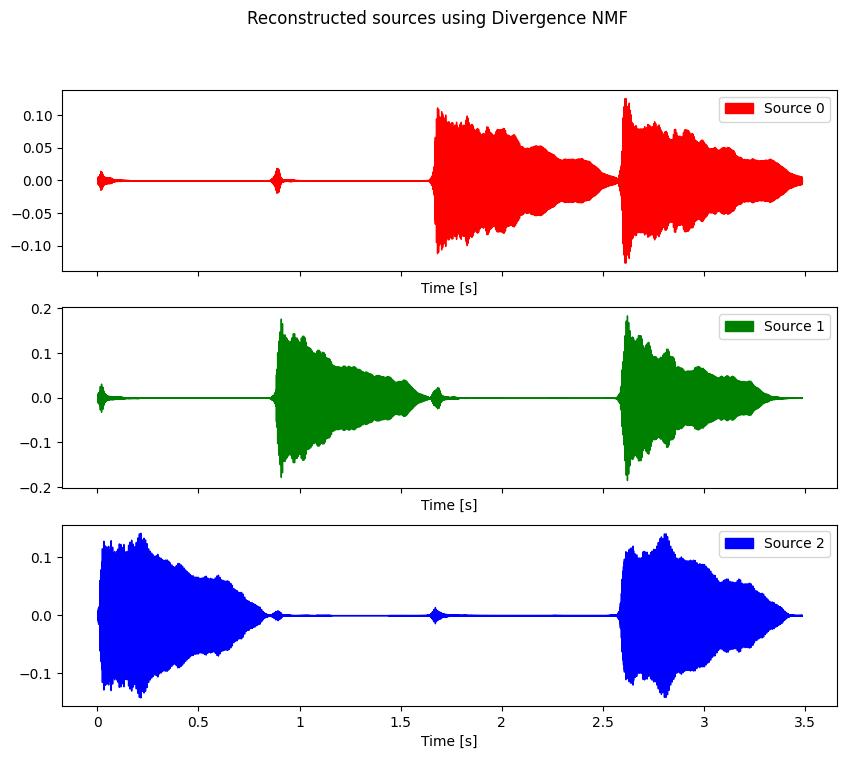

In [59]:
# Plotting the waveform
colors = ['r', 'g','b','c']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sounds_Divergence[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()


plt.suptitle('Reconstructed sources using Divergence NMF')
plt.show()

/tmp/ipykernel_136557/4258143412.py:5: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sounds_IS[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')


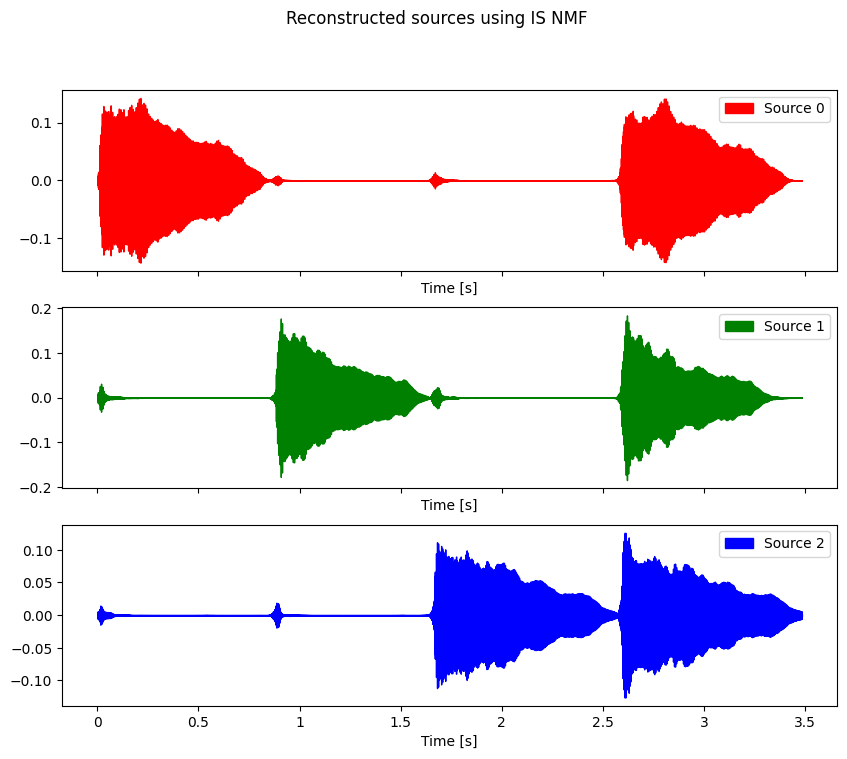

In [60]:
# Plotting the waveform
colors = ['r', 'g','b','c']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sounds_IS[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()


plt.suptitle('Reconstructed sources using IS NMF')
plt.show()

### Listennig to the recovered sources

#### Frobenius norm


In [61]:
for i in range(S):
    ipd.display(f"Source {i}",ipd.Audio(reconstructed_sounds_Frobenius[i],rate=sample_rate))

'Source 0'

'Source 1'

'Source 2'

#### Kullback-Leibler divergence

In [62]:
for i in range(S):
    ipd.display(f"Source {i}",ipd.Audio(reconstructed_sounds_Divergence[i],rate=sample_rate))

'Source 0'

'Source 1'

'Source 2'

#### Itakura-Saito divergence

In [63]:
for i in range(S):
    ipd.display(f"Source {i}",ipd.Audio(reconstructed_sounds_IS[i],rate=sample_rate))

'Source 0'

'Source 1'

'Source 2'